# Churn model - Training a simple classification model
In this tutorial we will cover how to implement a simple Machine Learning model to predict Customer's Churn following these steps:

- Import data into Databricks File System (DBFS)
- Explore and visualize data using popular libraries
- Run an optimization to get the best hyperparameters to the model
- Persist the best model using MLFlow

**Pre-Requisites**
* Conclude the steps before in the Lab 0

** This tutorial was inspired in the [databricks doc](https://docs.databricks.com/applications/machine-learning/train-model/scikit-learn.html)

## Get the data
We will use a learning purposes dataset created with simulated data. This dataset can be found [here](https://raw.githubusercontent.com/lfbraz/azure-databricks-mlops/master/dataset/dados_clientes.csv). We will download this dataset to `dbfs` to be able to import data to dataframes.

In [0]:
Customer = spark.read.parquet('/dbfs/Dataset/Customer')

We will develop a `sklearn` model so it will be easier to work with a Pandas Dataframe instead of a spark one (of course, when we are working in an spark environment it would be better to work with spark dataframes because of performance aspects, however for this tutorial we will use Pandas for learning reasons)

In [0]:
import pandas as pd

customer_data = Customer.toPandas()

In [0]:
customer_data.head(5)

Out[3]:

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,CEP,Pais,PaisCompleto,Email,RendaMensal,PercentualUtilizacaoLimite,QtdTransacoesNegadas,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn,UF_cleaned,mail_domain
0,1,Sra.,Fernanda,Camargo,32,Feminino,"Rua Paulo Suplicy, 376",São Paulo,SP,São Paulo,54210-520,BR,Brazil,fecamargo@gmail.com,8000,0.92,5,3,0,1,7,2,4,55229,65,Push,0,SP,gmail.com
1,2,Sr.,Paulo,Dias,63,Masculino,Estrada Transcastanhal 456,Castanhal,PA,Pará,68742-200,BR,Brazil,PauloPintoDias@gustr.com,4672,0.84,0,2,1,0,15,87,3,9936,66,Email,1,PA,gustr.com
2,3,Sr.,Enzo,Araujo,64,Masculino,Rua Joana D'Arc Gonçalves 576,Araxá,MG,Minas Gerais,38180-228,BR,Brazil,EnzoDiasAraujo@einrot.com,9751,0.20,14,19,0,0,1,5,4,769,30,SMS,1,MG,einrot.com
3,4,Sr.,Martim,Souza,59,Masculino,Rua Paulo Suplicy 376,São Paulo,SP,São Paulo,04637-010,BR,Brazil,MartimCastroSouza@superrito.com,7405,0.39,10,9,1,0,2,2,4,1246,76,Email,1,SP,superrito.com
4,5,Sr.,Gabriel,Barros,21,Masculino,Rua M 879,Valparaíso de Goiás,GO,Goiás,72870-040,BR,Brazil,GabrielCastroBarros@fleckens.hu,5102,0.50,7,16,0,0,3,4,4,2732,90,Email,0,GO,fleckens.hu


##Data Visualization

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, **IndiceSatisfacao** (An index that measure how satisfied a customer is with the service).

Out[4]:

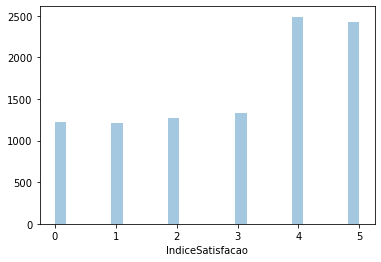

<matplotlib.axes._subplots.AxesSubplot at 0x7f67d9dbfe80>

In [0]:
import seaborn as sns
sns.distplot(customer_data.IndiceSatisfacao, kde=False)

Now we can analyse how the numeric features correlate each other, `pandas` have a native method `corr()` that use `pearson` correlation by default (you can alter this behavior using the *method* parameter).

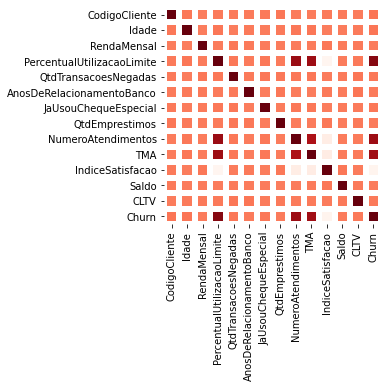

In [0]:
import matplotlib as plt

numeric_columns = []
for col in customer_data.columns:
  if(customer_data[col].dtypes!='object'):
    numeric_columns.append(col)
    
corr = customer_data[numeric_columns].corr()

ax1 = sns.heatmap(corr, cbar=0, linewidths=5, square=True, cmap='Reds')

## Preprocessing Data
Prior to training a model, check for missing values and split the data into training and validation sets.
In the last steps of this lab we already checked this point, so we cannot have any missing data

In [0]:
customer_data.isna().any()

Out[6]: CodigoCliente False
Titulo False
PrimeiroNome False
UltimoNome False
Idade False
Sexo False
Endereco False
Cidade False
UF False
UFCompleto False
CEP False
Pais False
PaisCompleto False
Email False
RendaMensal False
PercentualUtilizacaoLimite False
QtdTransacoesNegadas False
AnosDeRelacionamentoBanco False
JaUsouChequeEspecial False
QtdEmprestimos False
NumeroAtendimentos False
TMA False
IndiceSatisfacao False
Saldo False
CLTV False
CanalPref False
Churn False
UF_cleaned False
mail_domain False
dtype: bool

Indeed there is no missing data

## Train the model

First of all let's split train and test data

In [0]:
from sklearn.model_selection import train_test_split
SEED = 2020

train, test = train_test_split(customer_data, random_state=SEED, test_size=0.33)

In [0]:
train.head(1)

Out[8]:

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,CEP,Pais,PaisCompleto,Email,RendaMensal,PercentualUtilizacaoLimite,QtdTransacoesNegadas,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn,UF_cleaned,mail_domain
3888,3940,Sr.,Rodrigo,Souza,25,Masculino,Praça Padre Miguel Rua 459,São Paulo,SP,São Paulo,04149-060,BR,Brazil,RodrigoBarbosaSouza@rhyta.com,8104,0.93,0,11,0,1,17,179,2,6650,68,SMS,1,SP,rhyta.com


In [0]:
TARGET_COLUMN = 'Churn'
drop_columns = [TARGET_COLUMN, 'CodigoCliente'] 

X_train = train[numeric_columns].drop(drop_columns, axis=1)
X_test = test[numeric_columns].drop(drop_columns, axis=1)

y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

## Building a Baseline Model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn.

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

n_estimators = 10

model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(SEED))
model.fit(X_train, y_train)

Out[10]: RandomForestClassifier(n_estimators=10,
 random_state=RandomState(MT19937) at 0x7F67D8DE4C40)

In [0]:
# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]


In [0]:
y_pred = model.predict(X_test)

#### Model Evaluation

Get False and True Positive rate

Out[25]:

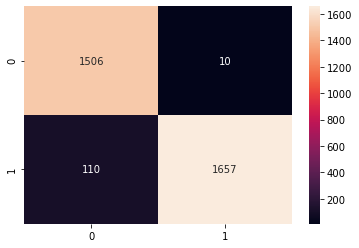

<matplotlib.axes._subplots.AxesSubplot at 0x7f67c210f3d0>

In [0]:
from sklearn.metrics import confusion_matrix
  
c_matrix_log = confusion_matrix(
  y_test, y_pred, labels=[0, 1])
sns.heatmap(
    c_matrix_log, annot=True, fmt="d")

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Results: ',
          str(model).split('(')[0], '\nPrecisão: {0:.2f}'.format(
              precision_score(y_test, y_pred)), '\nRecall: {0:.2f}'.format(
                  recall_score(y_test, y_pred)), '\nAUC: {0:.2f}'.format(
                      roc_auc_score(y_test, y_pred)),
          '\nAcurácia: {0:.2f}'.format(accuracy_score(y_test, y_pred)), '\n')

Results: RandomForestClassifier 
Precisão: 0.99 
Recall: 0.94 
AUC: 0.97 
Acurácia: 0.96

Plot ROC Curve

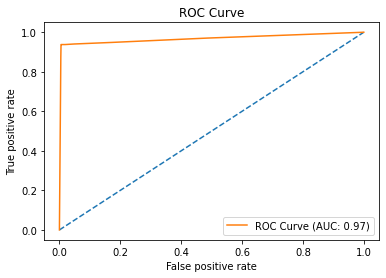

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, predictions_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr_rf, tpr_rf, label = 'ROC Curve (AUC: {0:.2f})'.format(
                      roc_auc_score(y_test, y_pred)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Seems to be a good model to begin. 😃

But let's try to make some improvements ...

First we will create an experiment to be able to track the **experiment**

## Create an experiment to track our models
MLflow Experiments can be created and organized in the Databricks Workspace just like a notebook, library, or folder. Simply click on an experiment to see a list of its runs or compare them. Crucially, with Managed MLflow, Experiments are integrated with Databricks’ standard role-based access controls to set sharing permissions.

In [0]:
import mlflow

experiment_name = '/churn-prediction'

if(not(mlflow.get_experiment_by_name(experiment_name))):
  mlflow.create_experiment(experiment_name)

Now we will try to optimize the hyperparameters of the model. We will use `hyperopt` (also inspired in this [doc](https://docs.databricks.com/applications/machine-learning/train-model/scikit-learn.html)) to be able to get the best parameters of our model. Mode details about `hyperopt` can be seen in this [link](https://docs.microsoft.com/en-us/azure/databricks/applications/machine-learning/automl-hyperparam-tuning/#hyperopt-overview). 

We will use `XGBoost` to try to increase the performance of our predictions as well.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
from mlflow.entities import ViewType
import numpy as np
import xgboost as xgb

mlflow.set_experiment(experiment_name)
run_name = 'XGBoost-model'

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  #'objective': 'binary:logistic',
  'objective': 'binary:hinge',
  'seed': SEED,
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()

  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    
    # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name=run_name):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=20,
    trials=spark_trials, 
    rstate=np.random.RandomState(SEED)
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/20 [00:00<?, ?trial/s, best loss=?] 10%|█ | 2/20 [00:09<01:23, 4.63s/trial, best loss: -0.9299050087129475] 20%|██ | 4/20 [00:10<00:54, 3.42s/trial, best loss: -0.9520532169217835] 30%|███ | 6/20 [00:13<00:40, 2.87s/trial, best loss: -0.9536554436137155] 40%|████ | 8/20 [00:14<00:26, 2.18s/trial, best loss: -0.9575195276044397] 45%|████▌ | 9/20 [00:15<00:20, 1.87s/trial, best loss: -0.9611943457673889] 50%|█████ | 10/20 [00:16<00:16, 1.61s/trial, best loss: -0.9611943457673889] 55%|█████▌ | 11/20 [00:18<00:15, 1.73s/trial, best loss: -0.9611943457673889] 65%|██████▌ | 13/20 [00:19<00:09, 1.36s/trial, best loss: -0.9611943457673889] 70%|███████ | 14/20 [00:20<00:07, 1.26s/trial, best loss: -0.9611943457673889] 85%|████████▌ | 17/20 [00:22<00:03, 1.08s/trial, best loss: -0.9611943457673889] 95%|█████████▌| 19/20 [00:25<00:01, 1.07s/trial, best loss: -0.9618071265490307]100%|██████████| 20/20 [00:26<00:00, 1.05s/trial, best loss: -0.9618071265490307]100%|██████████| 20/20 [00:26<00:00, 1.30s/trial, best loss: -0.9618071265490307]
Total Trials: 20: 20 succeeded, 0 failed, 0 cancelled.

### And the best run 😎

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC'],
                              run_view_type=ViewType.ACTIVE_ONLY,
                             ).iloc[0]

print(f'AUC of Best Run: {round(best_run["metrics.auc"], 2)}')

model_uri = "runs:/" + best_run["run_id"] + "/model"
print(f'model_uri: {model_uri}')

AUC of Best Run: 0.96
model_uri: runs:/8034024573c14f42928f432581b1c89f/model